In [1]:
# Import the required modules
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
##Reading in the dataset
df = pd.read_csv("cleaned_dataset.csv")
print(df.shape)
df.info()

(10000, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   transaction_id               10000 non-null  object 
 1   country                      10000 non-null  object 
 2   amount_usd                   10000 non-null  float64
 3   transaction_type             10000 non-null  object 
 4   date_of_transaction          10000 non-null  object 
 5   person_involved              10000 non-null  object 
 6   industry                     10000 non-null  object 
 7   destination_country          10000 non-null  object 
 8   reported_by_authority        10000 non-null  bool   
 9   source_of_money              10000 non-null  object 
 10  money_laundering_risk_score  10000 non-null  int64  
 11  shell_companies_involved     10000 non-null  int64  
 12  financial_institution        10000 non-null  object 
 13  tax_h

In [3]:
# Dropping columns that we dont need
df.drop(columns=["date_of_transaction", "person_involved", "financial_institution", "year"], inplace=True)

In [4]:
##Encoding features
meta = ['transaction_id']
num_features = ['amount_usd', 'money_laundering_risk_score', 'shell_companies_involved',]
cat_features = ['reported_by_authority', 'source_of_money', 'country', 'transaction_type', 'industry', 'destination_country', 'tax_haven_country', 'seasons', 'region']

In [5]:
# Checking to see if we need a scaler?
df_num = df.loc[:, num_features]
df_num.describe()

,amount_usd,money_laundering_risk_score,shell_companies_involved
count,1.000000e+04,10000.000000,10000.000000
mean,2.501818e+06,5.526400,4.469400
std,1.424364e+06,2.893603,2.879773
min,1.003180e+04,1.000000,0.000000
25%,1.279005e+06,3.000000,2.000000
50%,2.501310e+06,6.000000,4.000000
75%,3.722416e+06,8.000000,7.000000
max,4.999812e+06,10.000000,9.000000


In [6]:
# Lets use a scaler

# initialize
scaler = StandardScaler()

# fit
scaler.fit(df_num)

# predict/transform
scaled_data = scaler.transform(df_num)
df_scaled = pd.DataFrame(scaled_data, columns=num_features)

df_scaled.head()

,amount_usd,money_laundering_risk_score,shell_companies_involved
0,0.537609,0.163680,-1.204808
1,1.729945,1.200501,-1.552075
2,-1.690418,-1.564356,-0.510274
3,-1.485226,0.509287,-0.857541
4,-1.304815,-1.564356,1.573328


In [7]:
# Lets take a gander at the categorical features
df_cat = df.loc[:, cat_features]
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   reported_by_authority  10000 non-null  bool  
 1   source_of_money        10000 non-null  object
 2   country                10000 non-null  object
 3   transaction_type       10000 non-null  object
 4   industry               10000 non-null  object
 5   destination_country    10000 non-null  object
 6   tax_haven_country      10000 non-null  object
 7   seasons                10000 non-null  object
 8   region                 10000 non-null  object
dtypes: bool(1), object(8)
memory usage: 634.9+ KB


In [8]:
# Label encode if reported to authority and source
df_cat["reported_by_authority"] = df_cat["reported_by_authority"].apply(lambda x: 0 if x else 1)
df_cat["source_of_money"] = df_cat.source_of_money.apply(lambda x: 1 if x == 'Illegal' else 0)
df_cat.head()

,reported_by_authority,source_of_money,country,transaction_type,industry,destination_country,tax_haven_country,seasons,region
0,0,1,Brazil,Offshore Transfer,Construction,USA,Singapore,summer,South America
1,1,1,China,Stocks Transfer,Luxury Goods,South Africa,Bahamas,winter,Asia
2,0,1,UK,Stocks Transfer,Construction,Switzerland,Switzerland,winter,Europe
3,1,1,UAE,Cash Withdrawal,Oil & Gas,Russia,Panama,winter,Middle East
4,0,1,South Africa,Cryptocurrency,Real Estate,USA,Luxembourg,summer,Africa


In [9]:
# One Hot Encoding
df_cat = pd.get_dummies(df_cat, dtype=int)
df_cat.head()

,reported_by_authority,source_of_money,country_Brazil,country_China,country_India,country_Russia,country_Singapore,country_South Africa,country_Switzerland,country_UAE,country_UK,country_USA,transaction_type_Cash Withdrawal,transaction_type_Cryptocurrency,transaction_type_Offshore Transfer,transaction_type_Property Purchase,transaction_type_Stocks Transfer,industry_Arms Trade,industry_Casinos,industry_Construction,industry_Finance,industry_Luxury Goods,industry_Oil & Gas,industry_Real Estate,destination_country_Brazil,destination_country_China,destination_country_India,destination_country_Russia,destination_country_Singapore,destination_country_South Africa,destination_country_Switzerland,destination_country_UAE,destination_country_UK,destination_country_USA,tax_haven_country_Bahamas,tax_haven_country_Cayman Islands,tax_haven_country_Luxembourg,tax_haven_country_Panama,tax_haven_country_Singapore,tax_haven_country_Switzerland,seasons_fall,seasons_spring,seasons_summer,seasons_winter,region_Africa,region_Asia,region_Europe,region_Middle East,region_North America,region_South America
0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
3,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
4,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0


In [10]:
# Lets get the band back together

df_final = df.loc[:, meta]
df_final = pd.concat([df_final, df_scaled], axis=1)
df_final = pd.concat([df_final, df_cat], axis=1)
df_final.head()

,transaction_id,amount_usd,money_laundering_risk_score,shell_companies_involved,reported_by_authority,source_of_money,country_Brazil,country_China,country_India,country_Russia,country_Singapore,country_South Africa,country_Switzerland,country_UAE,country_UK,country_USA,transaction_type_Cash Withdrawal,transaction_type_Cryptocurrency,transaction_type_Offshore Transfer,transaction_type_Property Purchase,transaction_type_Stocks Transfer,industry_Arms Trade,industry_Casinos,industry_Construction,industry_Finance,industry_Luxury Goods,industry_Oil & Gas,industry_Real Estate,destination_country_Brazil,destination_country_China,destination_country_India,destination_country_Russia,destination_country_Singapore,destination_country_South Africa,destination_country_Switzerland,destination_country_UAE,destination_country_UK,destination_country_USA,tax_haven_country_Bahamas,tax_haven_country_Cayman Islands,tax_haven_country_Luxembourg,tax_haven_country_Panama,tax_haven_country_Singapore,tax_haven_country_Switzerland,seasons_fall,seasons_spring,seasons_summer,seasons_winter,region_Africa,region_Asia,region_Europe,region_Middle East,region_North America,region_South America
0,TX0000000001,0.537609,0.163680,-1.204808,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
1,TX0000000002,1.729945,1.200501,-1.552075,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2,TX0000000003,-1.690418,-1.564356,-0.510274,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
3,TX0000000004,-1.485226,0.509287,-0.857541,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
4,TX0000000005,-1.304815,-1.564356,1.573328,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0


In [11]:
# Isolate the IDs for later
ids = df_final.transaction_id
df_final.drop(columns=["transaction_id"], inplace=True)
df_final.head()

,amount_usd,money_laundering_risk_score,shell_companies_involved,reported_by_authority,source_of_money,country_Brazil,country_China,country_India,country_Russia,country_Singapore,country_South Africa,country_Switzerland,country_UAE,country_UK,country_USA,transaction_type_Cash Withdrawal,transaction_type_Cryptocurrency,transaction_type_Offshore Transfer,transaction_type_Property Purchase,transaction_type_Stocks Transfer,industry_Arms Trade,industry_Casinos,industry_Construction,industry_Finance,industry_Luxury Goods,industry_Oil & Gas,industry_Real Estate,destination_country_Brazil,destination_country_China,destination_country_India,destination_country_Russia,destination_country_Singapore,destination_country_South Africa,destination_country_Switzerland,destination_country_UAE,destination_country_UK,destination_country_USA,tax_haven_country_Bahamas,tax_haven_country_Cayman Islands,tax_haven_country_Luxembourg,tax_haven_country_Panama,tax_haven_country_Singapore,tax_haven_country_Switzerland,seasons_fall,seasons_spring,seasons_summer,seasons_winter,region_Africa,region_Asia,region_Europe,region_Middle East,region_North America,region_South America
0,0.537609,0.163680,-1.204808,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
1,1.729945,1.200501,-1.552075,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2,-1.690418,-1.564356,-0.510274,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
3,-1.485226,0.509287,-0.857541,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
4,-1.304815,-1.564356,1.573328,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0


In [12]:
##Adding back in a few columns
df_final["month"] = df.month
df_final["hemisphere"] = df.hemisphere
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   amount_usd                          10000 non-null  float64
 1   money_laundering_risk_score         10000 non-null  float64
 2   shell_companies_involved            10000 non-null  float64
 3   reported_by_authority               10000 non-null  int64  
 4   source_of_money                     10000 non-null  int64  
 5   country_Brazil                      10000 non-null  int32  
 6   country_China                       10000 non-null  int32  
 7   country_India                       10000 non-null  int32  
 8   country_Russia                      10000 non-null  int32  
 9   country_Singapore                   10000 non-null  int32  
 10  country_South Africa                10000 non-null  int32  
 11  country_Switzerland                 10000 

In [13]:
# Feature selection
# correlation analysis
corrs = df_final.corr()
corrs

,amount_usd,money_laundering_risk_score,shell_companies_involved,reported_by_authority,source_of_money,country_Brazil,country_China,country_India,country_Russia,country_Singapore,country_South Africa,country_Switzerland,country_UAE,country_UK,country_USA,transaction_type_Cash Withdrawal,transaction_type_Cryptocurrency,transaction_type_Offshore Transfer,transaction_type_Property Purchase,transaction_type_Stocks Transfer,industry_Arms Trade,industry_Casinos,industry_Construction,industry_Finance,industry_Luxury Goods,industry_Oil & Gas,industry_Real Estate,destination_country_Brazil,destination_country_China,destination_country_India,destination_country_Russia,destination_country_Singapore,destination_country_South Africa,destination_country_Switzerland,destination_country_UAE,destination_country_UK,destination_country_USA,tax_haven_country_Bahamas,tax_haven_country_Cayman Islands,tax_haven_country_Luxembourg,tax_haven_country_Panama,tax_haven_country_Singapore,tax_haven_country_Switzerland,seasons_fall,seasons_spring,seasons_summer,seasons_winter,region_Africa,region_Asia,region_Europe,region_Middle East,region_North America,region_South America,month,hemisphere
amount_usd,1.000000,0.016529,-0.017905,-0.005214,-0.011386,-0.000809,0.021818,-0.002150,-0.000039,0.001533,0.002140,0.003539,-0.002717,-0.002121,-0.021843,0.001999,0.006722,0.009027,-0.018486,0.001110,0.012692,-0.005406,0.010555,0.009057,-0.010394,-0.009966,-0.006831,-0.006355,-0.002186,-0.007122,-0.007517,0.012167,0.009054,0.014437,-0.007190,0.003461,-0.008373,-0.009356,0.000117,0.000218,-0.000476,0.002802,0.006692,0.016106,-0.006335,-0.003236,-0.005627,0.002140,0.014091,0.000879,-0.002717,-0.021843,-0.000809,0.001579,-0.001008
money_laundering_risk_score,0.016529,1.000000,-0.019262,-0.003502,0.002059,0.006140,-0.001859,0.009936,-0.011284,0.006839,-0.005819,0.003537,-0.005446,0.001858,-0.003870,0.004146,-0.003351,-0.009477,-0.003323,0.012061,0.006216,0.004127,0.008168,0.026662,-0.021834,-0.013583,-0.010091,0.014507,-0.008003,-0.021613,0.002743,0.001052,0.016948,-0.009450,0.003199,-0.006553,0.007462,-0.016474,-0.002058,0.012858,-0.006788,-0.008616,0.021159,0.016530,-0.010820,-0.005093,-0.000266,-0.005819,0.009685,-0.003855,-0.005446,-0.003870,0.006140,-0.010028,-0.000202
shell_companies_involved,-0.017905,-0.019262,1.000000,-0.020544,0.006620,0.009211,0.013864,-0.015895,0.003826,-0.016016,-0.004990,0.006135,0.004548,-0.012191,0.011515,-0.012246,0.019885,0.011206,-0.007792,-0.010871,0.010392,0.017398,-0.013702,0.009072,-0.007757,-0.016857,0.001547,0.013836,-0.002659,0.007372,-0.000551,-0.006361,-0.000493,-0.006671,0.027537,-0.022122,-0.009363,0.007508,-0.001926,0.002966,0.010970,-0.008404,-0.011399,0.002353,-0.013162,0.005467,0.004621,-0.004990,-0.011569,-0.001541,0.004548,0.011515,0.009211,-0.019785,-0.003122
reported_by_authority,-0.005214,-0.003502,-0.020544,1.000000,0.003226,0.013869,-0.003178,0.017140,-0.004253,-0.013770,0.008818,-0.007969,-0.017095,-0.002228,0.008501,0.017926,-0.000887,-0.016929,-0.008457,0.008514,0.008249,-0.026030,0.017493,0.008267,-0.018021,0.004418,0.005204,0.008038,-0.001095,0.002394,-0.010235,0.000249,-0.010630,0.000748,0.012224,-0.012855,0.011136,0.002986,-0.027391,0.003367,0.009528,0.008506,0.002986,-0.000433,-0.002217,0.002569,-0.000014,0.008818,0.000061,-0.009434,-0.017095,0.008501,0.013869,0.008236,-0.017018
source_of_money,-0.011386,0.002059,0.006620,0.003226,1.000000,0.030584,-0.012444,0.000232,0.001025,-0.009632,0.005803,-0.003062,0.000104,-0.002552,-0.010144,0.007702,-0.007939,-0.004040,0.001750,0.002483,0.003636,0.017608,-0.013297,-0.005552,0.003851,0.004617,-0.010296,-0.001953,-0.014572,0.008511,-0.003056,-0.000728,0.018318,-0.009217,0.007645,-0.025254,0.019515,-0.013835,0.001142,0.006103,0.006877,-0.000351,-0.000218,0.000853,0.006060,0.001581,-0.007648,0.005803,-0.014392,-0.003003,0.000104,-0.010144,0.030584,0.009534,-0.027239
country_Brazil,-0.000809,0.006140,0.009211,0.013869,0.030584,1.000000,-0.113820,-0.110861,-0.111295,-0.11

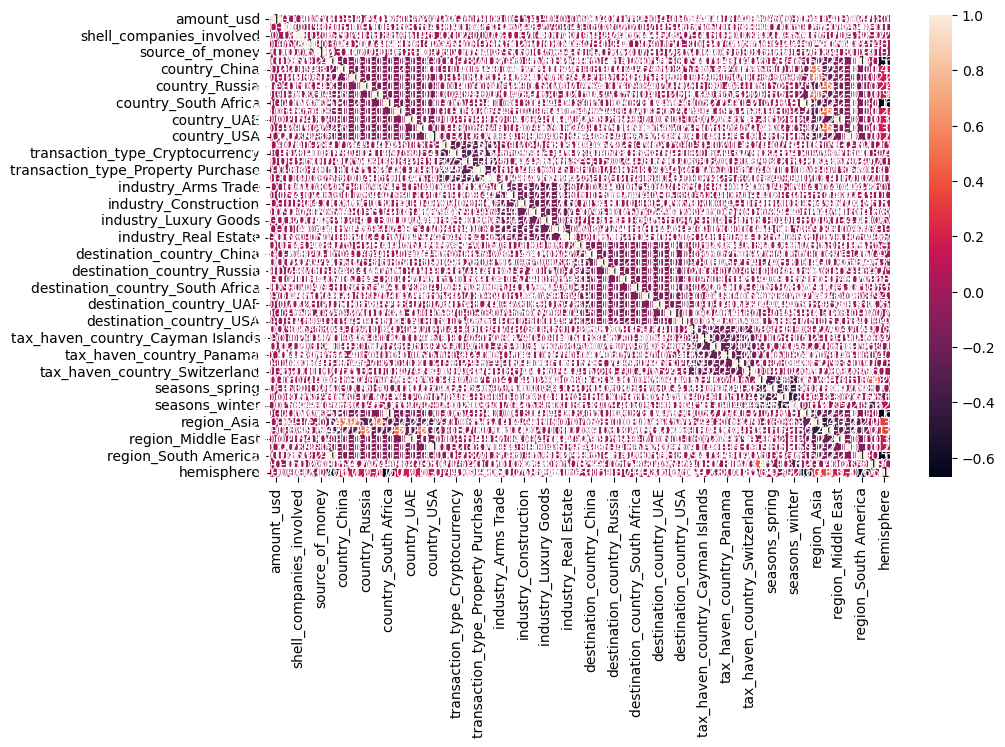

In [14]:
##This is garbage
plt.figure(figsize=(10,6))
sns.heatmap(corrs, annot=True)
plt.show()

In [15]:
##Taking a gander at the correlations
df_corrs = pd.DataFrame(abs(corrs.source_of_money).sort_values(ascending=False))
df_corrs.head(40)

,source_of_money
source_of_money,1.000000
region_South America,0.030584
country_Brazil,0.030584
hemisphere,0.027239
destination_country_UK,0.025254
destination_country_USA,0.019515
destination_country_South Africa,0.018318
industry_Casinos,0.017608
destination_country_China,0.014572
region_Asia,0.014392


In [16]:
df_final.to_csv("scaled_dataset.csv", index=False)

In [17]:
# #Lets drop some less important columns
# df_final.drop(columns=['destination_country_Switzerland', 'destination_country_India', 'transaction_type_Cryptocurrency', 
#                        'transaction_type_Cash Withdrawal', 'seasons_winter', 'destination_country_UAE', 'tax_haven_country_Panama', 
#                        'shell_companies_involved', 'tax_haven_country_Luxembourg', 'seasons_spring', 'region_Southern Africa', 
#                        'country_South Africa', 'industry_Finance', 'industry_Oil & Gas', 'transaction_type_Offshore Transfer', 
#                        'industry_Luxury Goods', 'industry_Arms Trade', 'reported_by_authority_1', 'reported_by_authority_0', 
#                        'region_Western Europe', 'country_Switzerland', 'destination_country_Russia', 'country_UK', 'region_Northern Europe', 
#                        'transaction_type_Stocks Transfer', 'money_laundering_risk_score', 'destination_country_Brazil', 
#                        'transaction_type_Property Purchase', 'seasons_summer', 'tax_haven_country_Cayman Islands', 'region_Eastern Europe', 
#                        'country_Russia', 'seasons_fall', 'destination_country_Singapore', 'tax_haven_country_Singapore', 'country_India', 
#                        'region_Southern Asia', 'tax_haven_country_Switzerland', 'region_Western Asia', 'country_UAE' ], inplace=True)

In [18]:
# Lets do this again
# correlation analysis
corrs = df_final.corr()
corrs

,amount_usd,money_laundering_risk_score,shell_companies_involved,reported_by_authority,source_of_money,country_Brazil,country_China,country_India,country_Russia,country_Singapore,country_South Africa,country_Switzerland,country_UAE,country_UK,country_USA,transaction_type_Cash Withdrawal,transaction_type_Cryptocurrency,transaction_type_Offshore Transfer,transaction_type_Property Purchase,transaction_type_Stocks Transfer,industry_Arms Trade,industry_Casinos,industry_Construction,industry_Finance,industry_Luxury Goods,industry_Oil & Gas,industry_Real Estate,destination_country_Brazil,destination_country_China,destination_country_India,destination_country_Russia,destination_country_Singapore,destination_country_South Africa,destination_country_Switzerland,destination_country_UAE,destination_country_UK,destination_country_USA,tax_haven_country_Bahamas,tax_haven_country_Cayman Islands,tax_haven_country_Luxembourg,tax_haven_country_Panama,tax_haven_country_Singapore,tax_haven_country_Switzerland,seasons_fall,seasons_spring,seasons_summer,seasons_winter,region_Africa,region_Asia,region_Europe,region_Middle East,region_North America,region_South America,month,hemisphere
amount_usd,1.000000,0.016529,-0.017905,-0.005214,-0.011386,-0.000809,0.021818,-0.002150,-0.000039,0.001533,0.002140,0.003539,-0.002717,-0.002121,-0.021843,0.001999,0.006722,0.009027,-0.018486,0.001110,0.012692,-0.005406,0.010555,0.009057,-0.010394,-0.009966,-0.006831,-0.006355,-0.002186,-0.007122,-0.007517,0.012167,0.009054,0.014437,-0.007190,0.003461,-0.008373,-0.009356,0.000117,0.000218,-0.000476,0.002802,0.006692,0.016106,-0.006335,-0.003236,-0.005627,0.002140,0.014091,0.000879,-0.002717,-0.021843,-0.000809,0.001579,-0.001008
money_laundering_risk_score,0.016529,1.000000,-0.019262,-0.003502,0.002059,0.006140,-0.001859,0.009936,-0.011284,0.006839,-0.005819,0.003537,-0.005446,0.001858,-0.003870,0.004146,-0.003351,-0.009477,-0.003323,0.012061,0.006216,0.004127,0.008168,0.026662,-0.021834,-0.013583,-0.010091,0.014507,-0.008003,-0.021613,0.002743,0.001052,0.016948,-0.009450,0.003199,-0.006553,0.007462,-0.016474,-0.002058,0.012858,-0.006788,-0.008616,0.021159,0.016530,-0.010820,-0.005093,-0.000266,-0.005819,0.009685,-0.003855,-0.005446,-0.003870,0.006140,-0.010028,-0.000202
shell_companies_involved,-0.017905,-0.019262,1.000000,-0.020544,0.006620,0.009211,0.013864,-0.015895,0.003826,-0.016016,-0.004990,0.006135,0.004548,-0.012191,0.011515,-0.012246,0.019885,0.011206,-0.007792,-0.010871,0.010392,0.017398,-0.013702,0.009072,-0.007757,-0.016857,0.001547,0.013836,-0.002659,0.007372,-0.000551,-0.006361,-0.000493,-0.006671,0.027537,-0.022122,-0.009363,0.007508,-0.001926,0.002966,0.010970,-0.008404,-0.011399,0.002353,-0.013162,0.005467,0.004621,-0.004990,-0.011569,-0.001541,0.004548,0.011515,0.009211,-0.019785,-0.003122
reported_by_authority,-0.005214,-0.003502,-0.020544,1.000000,0.003226,0.013869,-0.003178,0.017140,-0.004253,-0.013770,0.008818,-0.007969,-0.017095,-0.002228,0.008501,0.017926,-0.000887,-0.016929,-0.008457,0.008514,0.008249,-0.026030,0.017493,0.008267,-0.018021,0.004418,0.005204,0.008038,-0.001095,0.002394,-0.010235,0.000249,-0.010630,0.000748,0.012224,-0.012855,0.011136,0.002986,-0.027391,0.003367,0.009528,0.008506,0.002986,-0.000433,-0.002217,0.002569,-0.000014,0.008818,0.000061,-0.009434,-0.017095,0.008501,0.013869,0.008236,-0.017018
source_of_money,-0.011386,0.002059,0.006620,0.003226,1.000000,0.030584,-0.012444,0.000232,0.001025,-0.009632,0.005803,-0.003062,0.000104,-0.002552,-0.010144,0.007702,-0.007939,-0.004040,0.001750,0.002483,0.003636,0.017608,-0.013297,-0.005552,0.003851,0.004617,-0.010296,-0.001953,-0.014572,0.008511,-0.003056,-0.000728,0.018318,-0.009217,0.007645,-0.025254,0.019515,-0.013835,0.001142,0.006103,0.006877,-0.000351,-0.000218,0.000853,0.006060,0.001581,-0.007648,0.005803,-0.014392,-0.003003,0.000104,-0.010144,0.030584,0.009534,-0.027239
country_Brazil,-0.000809,0.006140,0.009211,0.013869,0.030584,1.000000,-0.113820,-0.110861,-0.111295,-0.11

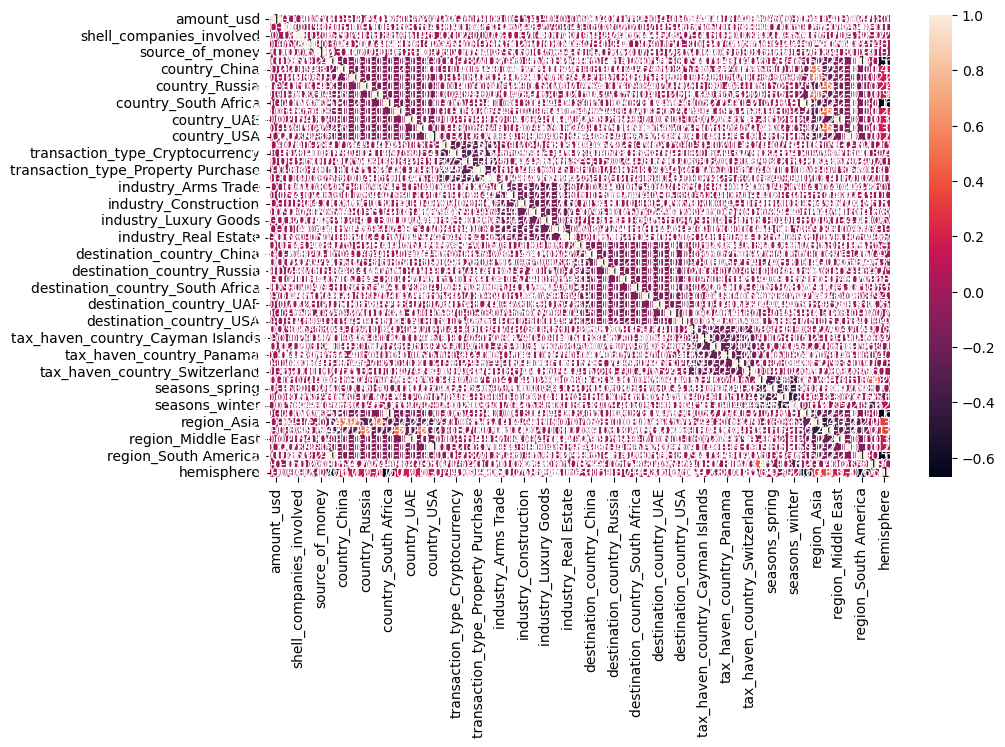

In [19]:
##This is garbage
plt.figure(figsize=(10,6))
sns.heatmap(corrs, annot=True)
plt.show()

In [20]:
##Taking a gander at the correlations
df_corrs = pd.DataFrame(abs(corrs.source_of_money).sort_values(ascending=False))
df_corrs.head(40)

,source_of_money
source_of_money,1.000000
region_South America,0.030584
country_Brazil,0.030584
hemisphere,0.027239
destination_country_UK,0.025254
destination_country_USA,0.019515
destination_country_South Africa,0.018318
industry_Casinos,0.017608
destination_country_China,0.014572
region_Asia,0.014392


In [21]:
# Step 1: Get the data
X = df_final.drop(columns=["source_of_money"])
y = df_final.source_of_money

sm = SMOTE(random_state =42)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) # stratify=True maintains target class percentages
X_train, y_train = sm.fit_resample(X_train, y_train)

In [22]:
# Function for Classification
# THE ROC CURVE CODE WILL BREAK FOR MULTI_CLASS PROBLEMS
def doClassification(model, X_train, X_test, y_train, y_test):
    # Step 3: Fit the model
    model.fit(X_train, y_train)
    
    # Step 4: Evaluate the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]

    # Generate metrics TRAIN
    train_cf = confusion_matrix(y_train, train_preds)
    train_cr = classification_report(y_train, train_preds)
    train_auc = roc_auc_score(y_train, train_proba)
    
    train_results = f"""TRAIN METRICS
    Confusion Matrix: 
    {train_cf}
    
    AUC: {train_auc}

    Classification Report:
    {train_cr}
    """
    
    print(train_results)

    # Generate metrics TEST
    test_cf = confusion_matrix(y_test, test_preds)
    test_cr = classification_report(y_test, test_preds)
    test_auc = roc_auc_score(y_test, test_proba)
    
    test_results = f"""TEST METRICS
    Confusion Matrix: 
    {test_cf}
    
    AUC: {test_auc}

    Classification Report:
    {test_cr}
    """
    
    print(test_results)

    # VISUALIZE TEST RESULTS
    # Confusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(test_cf, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test.values, test_proba)
    
    # Set figure size
    plt.figure(figsize=(6, 6))
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {test_auc:.2f})')
    
    # Plot the diagonal reference line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    
    # Titles and labels
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Add grid and legend
    plt.grid(linestyle="--", color="lightgrey", alpha=0.75)
    plt.legend(loc="lower right")
    
    # Display the plot
    plt.show()

TRAIN METRICS
    Confusion Matrix: 
    [[5277    0]
 [   0 5277]]
    
    AUC: 1.0

    Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00      5277
           1       1.00      1.00      1.00      5277

    accuracy                           1.00     10554
   macro avg       1.00      1.00      1.00     10554
weighted avg       1.00      1.00      1.00     10554

    
TEST METRICS
    Confusion Matrix: 
    [[ 283  477]
 [ 583 1157]]
    
    AUC: 0.5186554748941319

    Classification Report:
                  precision    recall  f1-score   support

           0       0.33      0.37      0.35       760
           1       0.71      0.66      0.69      1740

    accuracy                           0.58      2500
   macro avg       0.52      0.52      0.52      2500
weighted avg       0.59      0.58      0.58      2500

    


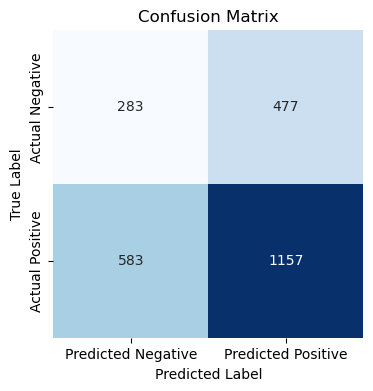

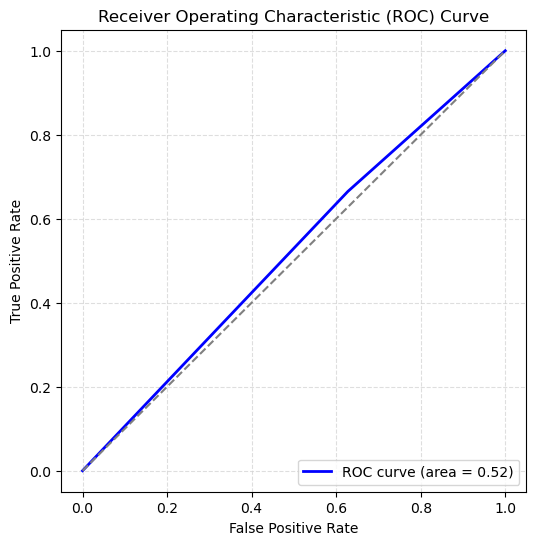

In [23]:
# Step 2: Init the Model
dt = DecisionTreeClassifier(random_state=42)

# Do Machine Learning
doClassification(dt, X_train, X_test, y_train, y_test)

In [24]:
fi = pd.DataFrame(list(zip(X.columns, dt.feature_importances_)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False)

,Feature,Importance
0,amount_usd,0.145260
25,industry_Real Estate,0.093274
2,shell_companies_involved,0.088149
1,money_laundering_risk_score,0.066549
52,month,0.065238
19,industry_Arms Trade,0.038006
22,industry_Finance,0.021446
39,tax_haven_country_Panama,0.018350
37,tax_haven_country_Cayman Islands,0.015877
3,reported_by_authority,0.014648


TRAIN METRICS
    Confusion Matrix: 
    [[5277    0]
 [   0 5277]]
    
    AUC: 1.0

    Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00      5277
           1       1.00      1.00      1.00      5277

    accuracy                           1.00     10554
   macro avg       1.00      1.00      1.00     10554
weighted avg       1.00      1.00      1.00     10554

    
TEST METRICS
    Confusion Matrix: 
    [[  79  681]
 [ 195 1545]]
    
    AUC: 0.5135688898971567

    Classification Report:
                  precision    recall  f1-score   support

           0       0.29      0.10      0.15       760
           1       0.69      0.89      0.78      1740

    accuracy                           0.65      2500
   macro avg       0.49      0.50      0.47      2500
weighted avg       0.57      0.65      0.59      2500

    


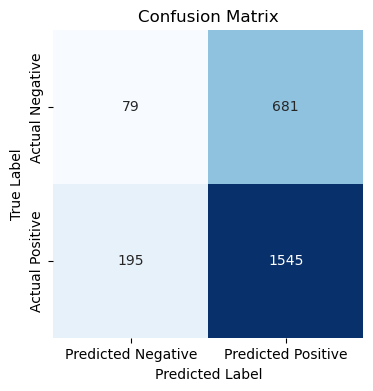

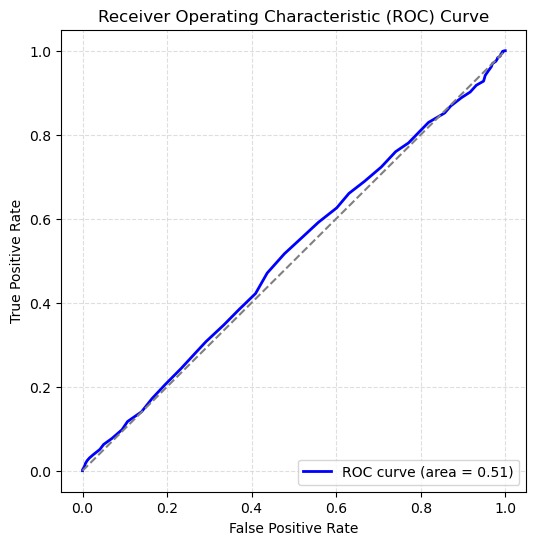

In [25]:
# Step 2: Init the Model
rf = RandomForestClassifier(random_state=42)

# Do Machine Learning
doClassification(rf, X_train, X_test, y_train, y_test)

In [26]:
fi = pd.DataFrame(list(zip(X.columns, rf.feature_importances_)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False)

,Feature,Importance
0,amount_usd,0.104614
2,shell_companies_involved,0.082289
1,money_laundering_risk_score,0.081831
52,month,0.064025
17,transaction_type_Property Purchase,0.019884
37,tax_haven_country_Cayman Islands,0.018219
3,reported_by_authority,0.017663
15,transaction_type_Cryptocurrency,0.017541
41,tax_haven_country_Switzerland,0.017484
18,transaction_type_Stocks Transfer,0.017294


TRAIN METRICS
    Confusion Matrix: 
    [[5277    0]
 [   0 5277]]
    
    AUC: 1.0

    Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00      5277
           1       1.00      1.00      1.00      5277

    accuracy                           1.00     10554
   macro avg       1.00      1.00      1.00     10554
weighted avg       1.00      1.00      1.00     10554

    
TEST METRICS
    Confusion Matrix: 
    [[ 118  642]
 [ 267 1473]]
    
    AUC: 0.5074413944343618

    Classification Report:
                  precision    recall  f1-score   support

           0       0.31      0.16      0.21       760
           1       0.70      0.85      0.76      1740

    accuracy                           0.64      2500
   macro avg       0.50      0.50      0.49      2500
weighted avg       0.58      0.64      0.59      2500

    


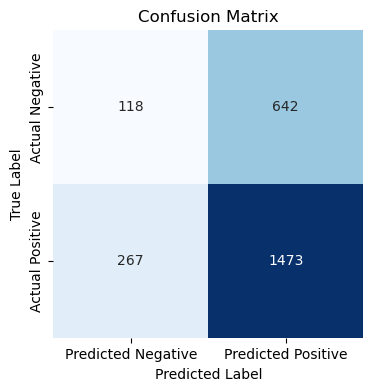

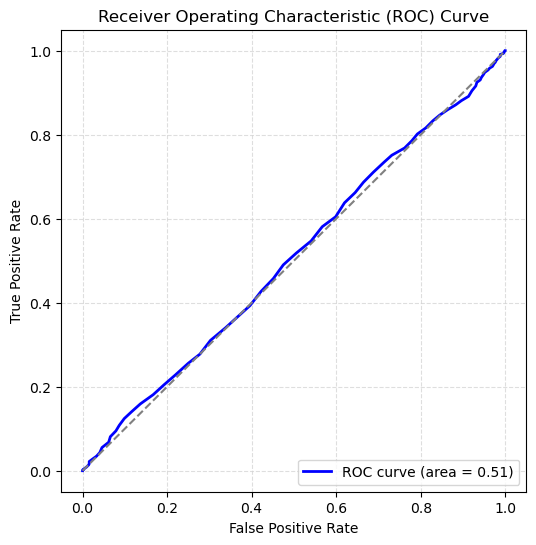

In [27]:
# Step 2: Init the Model
et = ExtraTreesClassifier(random_state=42)

# Do Machine Learning
doClassification(et, X_train, X_test, y_train, y_test)

In [28]:
fi = pd.DataFrame(list(zip(X.columns, et.feature_importances_)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False)

,Feature,Importance
0,amount_usd,0.057480
2,shell_companies_involved,0.053445
1,money_laundering_risk_score,0.053159
52,month,0.048298
3,reported_by_authority,0.023298
17,transaction_type_Property Purchase,0.022195
36,tax_haven_country_Bahamas,0.021958
37,tax_haven_country_Cayman Islands,0.021837
45,seasons_winter,0.021198
41,tax_haven_country_Switzerland,0.020490


TRAIN METRICS
    Confusion Matrix: 
    [[5277    0]
 [   0 5277]]
    
    AUC: 1.0

    Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00      5277
           1       1.00      1.00      1.00      5277

    accuracy                           1.00     10554
   macro avg       1.00      1.00      1.00     10554
weighted avg       1.00      1.00      1.00     10554

    
TEST METRICS
    Confusion Matrix: 
    [[ 164  596]
 [ 345 1395]]
    
    AUC: 0.5084452510586812

    Classification Report:
                  precision    recall  f1-score   support

           0       0.32      0.22      0.26       760
           1       0.70      0.80      0.75      1740

    accuracy                           0.62      2500
   macro avg       0.51      0.51      0.50      2500
weighted avg       0.59      0.62      0.60      2500

    


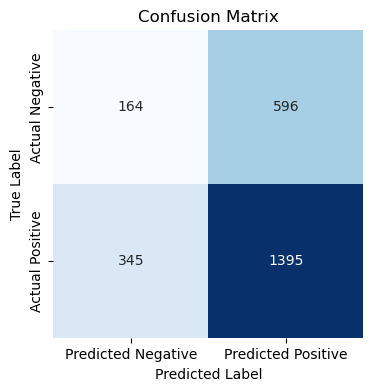

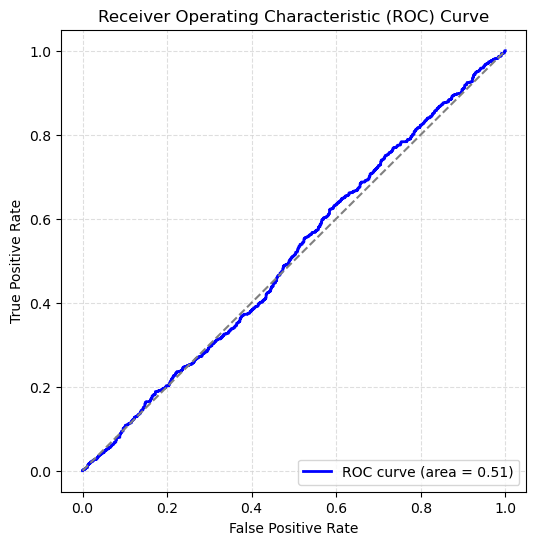

In [29]:
# Step 2: Init the Model
xgb = XGBClassifier(random_state=42, n_estimators = 1000)

# Do Machine Learning
doClassification(xgb, X_train, X_test, y_train, y_test)

In [30]:
fi = pd.DataFrame(list(zip(X.columns, xgb.feature_importances_)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False)

,Feature,Importance
36,tax_haven_country_Bahamas,0.053385
22,industry_Finance,0.050562
24,industry_Oil & Gas,0.039245
19,industry_Arms Trade,0.037731
16,transaction_type_Offshore Transfer,0.036416
28,destination_country_India,0.032206
20,industry_Casinos,0.031798
21,industry_Construction,0.031541
23,industry_Luxury Goods,0.031242
31,destination_country_South Africa,0.029777


TRAIN METRICS
    Confusion Matrix: 
    [[3593 1684]
 [  23 5254]]
    
    AUC: 0.9611474654707202

    Classification Report:
                  precision    recall  f1-score   support

           0       0.99      0.68      0.81      5277
           1       0.76      1.00      0.86      5277

    accuracy                           0.84     10554
   macro avg       0.88      0.84      0.83     10554
weighted avg       0.88      0.84      0.83     10554

    
TEST METRICS
    Confusion Matrix: 
    [[  39  721]
 [  72 1668]]
    
    AUC: 0.5088203266787659

    Classification Report:
                  precision    recall  f1-score   support

           0       0.35      0.05      0.09       760
           1       0.70      0.96      0.81      1740

    accuracy                           0.68      2500
   macro avg       0.52      0.50      0.45      2500
weighted avg       0.59      0.68      0.59      2500

    


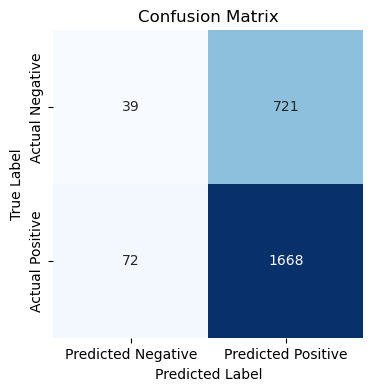

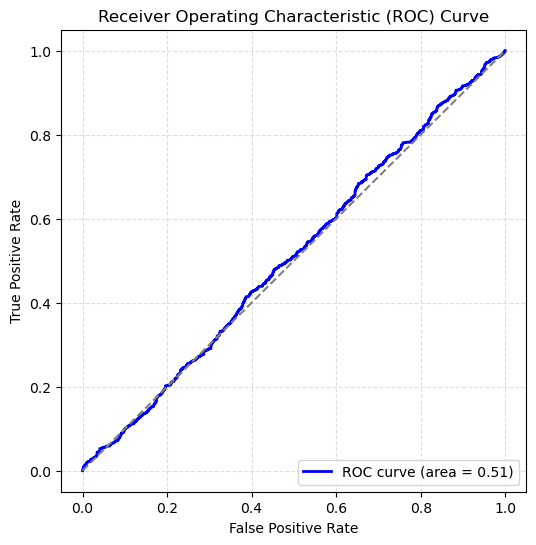

In [31]:
# Step 2: Init the Model
lgbm = LGBMClassifier(random_state=42, verbose=-1, n_estimators = 100)

# Do Machine Learning
doClassification(lgbm, X_train, X_test, y_train, y_test)

In [32]:
# Retrain the model on the ENTIRE dataset
lgbm =  LGBMClassifier(random_state=42, verbose=-1, n_estimators = 100)
lgbm.fit(X, y)

LGBMClassifier(random_state=42, verbose=-1)

In [33]:
# Save off my models
import pickle

# Scaler
pickle.dump(scaler, open("black_money_scaler.h5", 'wb'))

# Model
pickle.dump(lgbm, open("black_money_model.h5", 'wb'))